In [7]:
import torch
from torch import nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torch.optim import optimizer

import numpy as np
from PIL import Image
import pandas as pd
import os
import shutil
import zipfile
import random
import math

%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime

from utils import *

In [8]:
image_size = 256
batch_size = 16

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [10]:
# Custom Dataset Class

class CustomDataSet(Dataset):
    def __init__(self, folder_path, csv_path, transforms = None):
        #get all the necessary parameters for directories, labels and transforms
        self.csv = pd.read_csv(csv_path)
        self.folder_path = folder_path
        self.transforms = transforms

    def __len__(self):
        #get the length of the dataset
        class_length = len(self.csv.iloc[:, 1])
        return class_length

    def __getitem__(self, idx):
        #get the dataset item and label and set transforms
        self.image_path_list = [os.path.join(self.folder_path, image_name) for image_name in self.csv.iloc[:, 0]]
        self.one_hot_label = pd.get_dummies(self.csv.iloc[:, 1])
        self.one_hot_label_list = self.one_hot_label.values.tolist()

        self.image_path = self.image_path_list[idx]
        self.image = Image.open(self.image_path)
        self.label = torch.tensor(self.one_hot_label_list[idx]).float()

        if self.transforms:
            self.image = self.transforms(self.image)

        sample = {'image': self.image, 'label': self.label}

        return sample

# Custom transform

class CustomClipToRange():
  def __init__(self, floor, ceiling):
    self.floor = floor
    self.ceiling = ceiling
  def __call__(self, input):
    return torch.clamp(input=input, min=self.floor, max=self.ceiling)

In [11]:
# paths
train_folder_path = r'C://Users//rolan//Desktop//Wooden_things//train'
train_csv_path = r'C://Users//rolan//Desktop//Wooden_things//train_csv.csv'

test_folder_path = r'C://Users//rolan//Desktop//Wooden_things//test'
test_csv_path = r'C://Users//rolan//Desktop//Wooden_things//test_csv.csv'

# Set transforms
data_transforms = transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor(), CustomClipToRange(floor=0.001, ceiling = 0.999)])

#datasets
train_data = CustomDataSet(folder_path=train_folder_path, csv_path=train_csv_path, transforms=data_transforms)
test_data = CustomDataSet(folder_path=test_folder_path, csv_path=test_csv_path, transforms=data_transforms)

# DataLoader

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

In [ ]:
# Visualise batch
plot_batch_samples(train_loader, batch_size = batch_size)

In [21]:
# Import model
from classifier_model import LinearWood

# Move to GPU
wt_model = LinearWood().to(device=device)

# Loss function
loss_f = nn.CrossEntropyLoss()

# Optimiser
optim_f = torch.optim.SGD(wt_model.parameters(), lr=0.001, momentum=0.9)
#optim_f = torch.optim.Adam(params=wt_model.parameters(), lr=0.001)

In [22]:
# Train loop

def train(model, dataloader, loss_f, optim_f):
  # set the model to train mode?
  model.train()

  # for plotting loss with matplotlib
  loss_list = []

  for idx, x in enumerate(dataloader):

    # move inputs and labels to the GPU
    x, y = x['image'].to(device), x['label'].to(device)

    # forward pass
    prediction = model.forward(x)

    # calculate the loss
    loss = loss_f(prediction, y)

    # calculate the gradient
    loss.backward()

    # update weights with optimizer
    optim_f.step()

    # zero the gradients
    optim_f.zero_grad()

    #print the training loss
    if idx % 10 == 0:
      print(f'training loss = {loss.item()}')

    loss_list.append(loss.item())

  return loss_list

In [25]:
# Test loop

def test(model, dataloader, loss_f, dataset):
  # set the model to evaluate mode
  model.eval()
  loss_sum = 0
  accuracy_sum = 0

  #create loss and accuracy variables
  with torch.no_grad():

    # set a loop over the batches
    for x in dataloader:

      # move inputs and labels to the GPU #'image': self.image, 'label'
      x, y = x['image'].to(device), x['label'].to(device)

      # run the forwards pass
      prediction = model.forward(x)

      # calculate the loss
      loss = loss_f(prediction, y)

      # total loss over all the batches
      loss_sum += loss

      # toatl accuracy over all the batches
      accuracy_sum += (prediction.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

  # average loss
  avg_loss = loss_sum / len(dataloader)
  avg_loss = '{:f}'.format(avg_loss)

  #average accuracy
  avg_accuracy = accuracy_sum / len(dataset)

  # print the loss and accuracy
  print(f'Epoch loss = {avg_loss} \n Epoch accuracy = {avg_accuracy}')

  return avg_loss, avg_accuracy

Epoch1 
 --------------------------------------
training loss = 1.380199670791626
training loss = 1.3861186504364014
training loss = 1.3920435905456543
training loss = 1.3804806470870972
training loss = 1.3962030410766602
training loss = 1.387097716331482
Epoch loss = 1.386602 
 Epoch accuracy = 0.25
Saved model as Experiment_1.pth
Finished


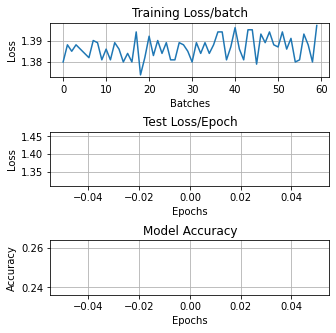

Epoch2 
 --------------------------------------
training loss = 1.381882905960083
training loss = 1.3804429769515991
training loss = 1.3981013298034668
training loss = 1.3912158012390137
training loss = 1.3805592060089111
training loss = 1.3894176483154297
Epoch loss = 1.386586 
 Epoch accuracy = 0.25
Finished


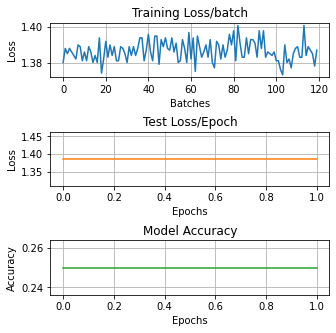

Epoch3 
 --------------------------------------
training loss = 1.3897252082824707
training loss = 1.3887953758239746
training loss = 1.3915644884109497
training loss = 1.387679100036621
training loss = 1.3881179094314575
training loss = 1.3835575580596924
Epoch loss = 1.386578 
 Epoch accuracy = 0.25
Finished


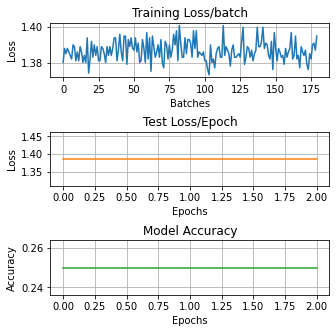

Epoch4 
 --------------------------------------
training loss = 1.3892654180526733
training loss = 1.390081524848938
training loss = 1.3937429189682007
training loss = 1.3847826719284058
training loss = 1.3825929164886475
training loss = 1.3803889751434326
Epoch loss = 1.386566 
 Epoch accuracy = 0.25
Finished


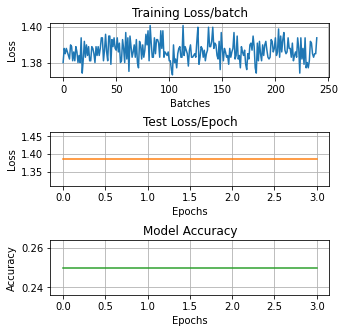

Epoch5 
 --------------------------------------
training loss = 1.3810982704162598
training loss = 1.3924927711486816
training loss = 1.3878061771392822
training loss = 1.3858952522277832
training loss = 1.3900432586669922
training loss = 1.3883793354034424
Epoch loss = 1.386562 
 Epoch accuracy = 0.25
Finished


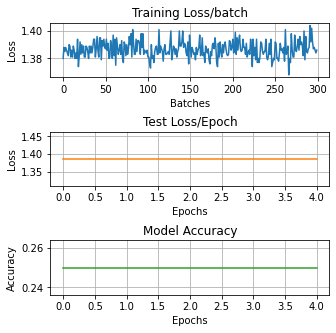

In [26]:
save_model_path = r'C://Users//rolan//Desktop//personal//Projects//Helpers//Trash//Wooden_things_model_checkpoints'
save_plot_path = r'C://Users//rolan//Desktop//personal//Projects//Helpers//Trash//Wooden_things_plots'

def train_loop(epochs):
    train_loss_list = []
    test_loss_list = []
    accuracy_list= []
    current_time = str(datetime.now()).replace(' ', '').replace('.', '').replace(':', '')

    for idx, i in enumerate(range(epochs)):
        print(f'Epoch{i+1} \n --------------------------------------')

        #train the model
        train_loss = train(model=wt_model, loss_f=loss_f, optim_f=optim_f, dataloader=train_loader)
        test_loss, accuracy = test(model=wt_model, loss_f=loss_f, dataloader=test_loader, dataset=test_data)

        '''plot the graphs as the model trains'''
        #sort the data for the plots        
        for i in train_loss:
            train_loss_list.append(round(i, 3))
        test_loss_list.append(round(float(test_loss), 3))
        accuracy_list.append(accuracy)

        #close previous plots to free up memory
        plt.close('all')
        
        #create and format the figure
        loss_fig, (ax_train, ax_test, ax_acc) = plt.subplots(nrows=3, ncols=1)
        loss_fig.set_size_inches(5, 5)
        loss_fig.set_dpi(72)
        plt.subplots_adjust(hspace=1, wspace=1)

        #plot the data on the axes
        ax_train.plot(list(range(len(train_loader)*(idx+1))), train_loss_list, color='#1f77b4')
        ax_train.set_title('Training Loss/batch')
        ax_train.set_xlabel('Batches')
        ax_train.set_ylabel('Loss')
        ax_train.grid(True)

        ax_test.plot(list(range(idx+1)), test_loss_list, color='#ff7f0e')
        ax_test.set_title('Test Loss/Epoch')
        ax_test.set_xlabel('Epochs')
        ax_test.set_ylabel('Loss')
        ax_test.grid(True)

        ax_acc.plot(list(range(idx+1)), accuracy_list, color='#2ca02c')
        ax_acc.set_title('Model Accuracy')
        ax_acc.set_xlabel('Epochs')
        ax_acc.set_ylabel('Accuracy')
        ax_acc.grid(True)

        #save the model
        a = 0
        if idx % 10 == 0:
            a += 1
            torch.save(obj = wt_model.state_dict, f=f'{save_model_path}//Experiment_{a}{current_time}.pth')
            print(f'Saved model as Experiment_{a}.pth')
        print('Finished')

        #plt.pause(0.1)
        plt.show()

        loss_fig.savefig(fname=f'{save_plot_path}//model_x_{current_time}.pdf', dpi=300)

train_loop(5)